####OPTIONAL PREPROCESSING FILE. USE: MAKE SURE THE ONSET TIMING IS CORRECT FOR THE PHOTODIODES BY PLOTTING differences in times between triggers

In [3]:
import mne
import pandas as pd
import numpy as np
import glob
import pylab
import pandas as pd
import pickle
import matplotlib.pyplot as plt


stim_duration = .3
run_length = 4
first_run_file = 1
last_run_file = 4
S = 'S19'
bids_top_dir = '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/'
#proj_path = "/misc/data12/sjapee/Sebastian-OrientationImagery/Data/"
#raw_dir = proj_path + '20240911/' + S + '/'
#logfile_dir = raw_dir + 'sheets/extracted_data'
bids_dir = bids_top_dir + f'bids_dir/sub-{S}/ses-1/meg/sub-{S}_ses-1_task-OrientationImagery'

In [4]:
#*****************************#
### PARAMETERS ###
#*****************************#

l_freq                      = 0.1
h_freq                      = 100
notch                       = 60
notch_max                   = 240
pre_stim_time               = -.2
post_stim_time              = .6
std_deviations_above_below  = 4
output_resolution           = 200
trigger_channel             = 'UPPT001'


import glob

dsets = []
for i in range(1, 5, 1):
    ds = f'run-{i:02}'  # Format the run number with leading zeros
    pattern = f'{bids_dir}_{ds}_meg.ds'  # Adjust the pattern to match your file name structure
    matches = glob.glob(pattern)
    
    if matches:
        dsets.append(matches[0])
    else:
        print(f"No files found for pattern: {pattern}")

print(dsets)



['/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/bids_dir/sub-S19/ses-1/meg/sub-S19_ses-1_task-OrientationImagery_run-01_meg.ds', '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/bids_dir/sub-S19/ses-1/meg/sub-S19_ses-1_task-OrientationImagery_run-02_meg.ds', '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/bids_dir/sub-S19/ses-1/meg/sub-S19_ses-1_task-OrientationImagery_run-03_meg.ds', '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/bids_dir/sub-S19/ses-1/meg/sub-S19_ses-1_task-OrientationImagery_run-04_meg.ds']


In [5]:
#New way of defining onsets not based on standard deviation but based on finding photodiode after the trigger
def defineOnsets(raw, events):
    log_statements = []
    raw.crop(0,raw.times[events[-1,0]]+10)
    pd_dat = raw[raw.ch_names.index('UADC016-2104')][0][0]
    print(np.mean(np.abs(pd_dat)))
    if np.mean(np.abs(pd_dat))>0.6: # this should be fine but may not be good if there are a looot of zeros
    # zero-centering & making everything positive
        pd_dat = np.abs(pd_dat-np.mean(pd_dat[0:100]))
        # scaling channel to 0-1
        pd_dat = (pd_dat-np.min(pd_dat)) / (np.max(pd_dat)-np.min(pd_dat))


        # using the event, we are now looking in the next 50ms of the photodiode channel (digital) when the signal goes above 0.5
        t_samples = int(0.05/(1/raw.info['sfreq']))
        threshold =  .5
        try:
            pd_events = [events[i,0]+np.where(pd_dat[events[i,0]:events[i,0]+t_samples]<threshold)[0][0] for i in range(len(events))]
        except:
            pd_events = [events[i,0]+np.where(pd_dat[events[i,0]:events[i,0]+t_samples]>threshold)[0][0] for i in range(len(events))]
        # when we found the events we calculate the trigger delay. 
        print(pd_events)
        pd_onsets = []
        pd_offsets = []

        for event in events:
            # Find onset
            onset_index = event[0] + np.argmax(pd_dat[event[0]:event[0] + t_samples] > threshold)
            #print('test', onset_index)
            pd_onsets.append(onset_index)

            # Find offset
            pd_offset_index = onset_index + np.argmax(pd_dat[onset_index:] < threshold)
            pd_offsets.append(pd_offset_index)
        trigger_delay = 1000. * (pd_events-events[:, 0]) / raw.info['sfreq']
        # sometimes this channel records ON as UP and sometimes as DOWN. This if-loop makes sure we always find the onsets
        if np.mean(trigger_delay)==0:
            pd_events = [events[i,0]+np.where(pd_dat[events[i,0]:events[i,0]+t_samples]>threshold)[0][0] for i in range(len(events))]
            trigger_delay = 1000. * (pd_events-events[:, 0]) / raw.info['sfreq']
        log_statements.append(('Trigger delay removed (μ ± σ): %0.1f ± %0.1f ms')
            % (np.mean(trigger_delay), np.std(trigger_delay)))
        if np.mean(trigger_delay)>10:
            events[:,0] = events[:,0]+5
            log_statements.append(f'photo diode and parallel port triggers are too far apart. using parallel port trigger ')
        else:
            log_statements.append(f'photo diode used successfully ')
            events[:, 0] = pd_events
    else: 
    # if the pd channel didn't work, add 5 samples as a standard delay
        events[:,0] = events[:,0]+5
        log_statements.append(f'photo diode did not record anything. using parallel port trigger ')
    return raw,events,log_statements, pd_onsets, pd_offsets


def notch_filter(raw):
    #apply notch filter based on global parameters set at the top
    notches = np.arange(notch, notch_max+1, notch)
    print(notches)
    raw.notch_filter(notches, phase='zero-double', fir_design='firwin2')
    return raw


In [6]:
event_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

ds directory : /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/bids_dir/sub-S19/ses-1/meg/sub-S19_ses-1_task-OrientationImagery_run-01_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -0.20   75.55    0.00 mm <->   -0.20   75.55   -0.00 mm (orig :  -45.58   60.72 -255.55 mm) diff =    0.000 mm
       0.20  -75.55    0.00 mm <->    0.20  -75.55   -0.00 mm (orig :   60.23  -47.00 -250.03 mm) diff =    0.000 mm
      82.24    0.00    0.00 mm <->   82.24   -0.00    0.00 mm (orig :   66.17   64.09 -257.82 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/bids_dir/sub-S19/ses-1/meg/sub-S19_ses-1_task-OrientationImagery_run-0

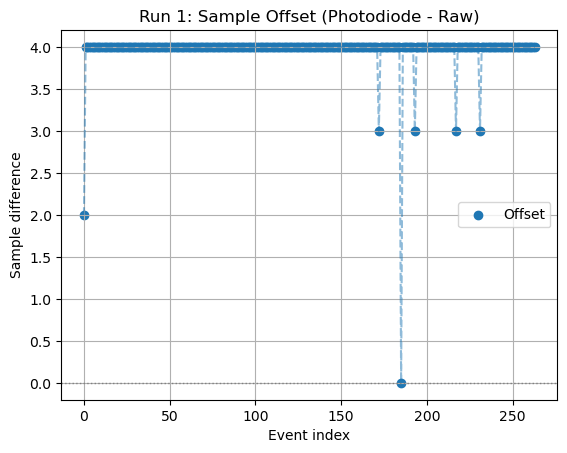

ds directory : /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/bids_dir/sub-S19/ses-1/meg/sub-S19_ses-1_task-OrientationImagery_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       1.39   75.61    0.00 mm <->    1.39   75.61    0.00 mm (orig :  -39.61   64.22 -266.46 mm) diff =    0.000 mm
      -1.39  -75.61    0.00 mm <->   -1.39  -75.61    0.00 mm (orig :   63.60  -46.08 -259.08 mm) diff =    0.000 mm
      83.40    0.00    0.00 mm <->   83.40   -0.00   -0.00 mm (orig :   71.89   66.87 -267.94 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/bids_dir/sub-S19/ses-1/meg/sub-S19_ses-1_task-OrientationImagery_run-0

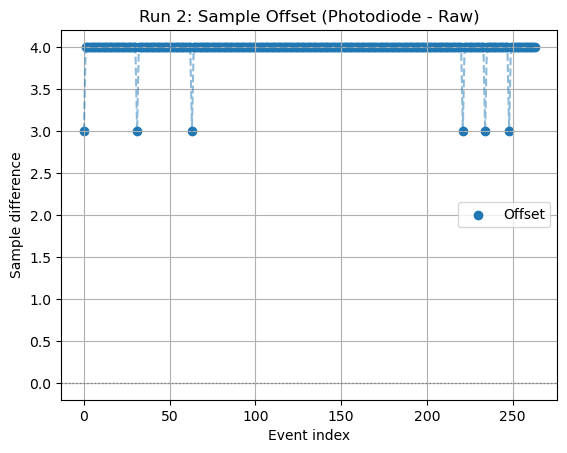

ds directory : /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/bids_dir/sub-S19/ses-1/meg/sub-S19_ses-1_task-OrientationImagery_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       1.84   75.61    0.00 mm <->    1.84   75.61    0.00 mm (orig :  -37.83   64.55 -270.42 mm) diff =    0.000 mm
      -1.84  -75.61    0.00 mm <->   -1.84  -75.61   -0.00 mm (orig :   61.20  -49.60 -263.75 mm) diff =    0.000 mm
      83.59    0.00    0.00 mm <->   83.59    0.00    0.00 mm (orig :   73.39   63.20 -275.69 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/bids_dir/sub-S19/ses-1/meg/sub-S19_ses-1_task-OrientationImagery_run-0

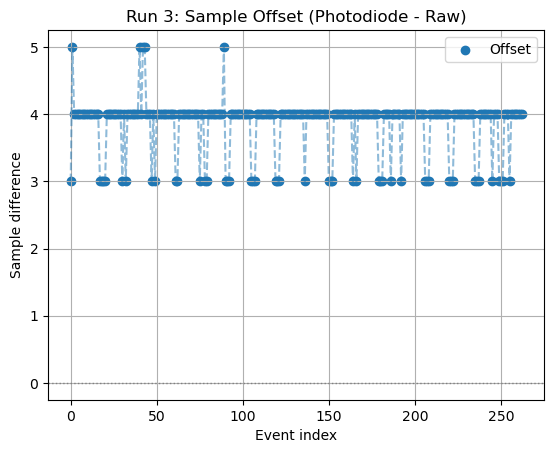

ds directory : /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/bids_dir/sub-S19/ses-1/meg/sub-S19_ses-1_task-OrientationImagery_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       1.24   75.63    0.00 mm <->    1.24   75.63    0.00 mm (orig :  -39.99   65.01 -267.28 mm) diff =    0.000 mm
      -1.24  -75.63    0.00 mm <->   -1.24  -75.63    0.00 mm (orig :   61.08  -47.53 -265.38 mm) diff =    0.000 mm
      83.84    0.00    0.00 mm <->   83.84   -0.00    0.00 mm (orig :   71.75   65.41 -274.76 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/bids_dir/sub-S19/ses-1/meg/sub-S19_ses-1_task-OrientationImagery_run-0

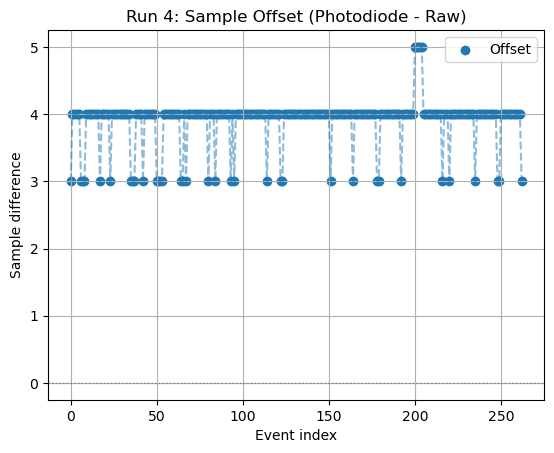

In [7]:
from mne.preprocessing import ICA


all_epochs = []
all_events = []
for i in range(len(dsets)):
    raw = mne.io.read_raw_ctf(dsets[i],system_clock='ignore',preload=True)
    events = mne.find_events(raw, stim_channel='UPPT001',min_duration = 0.002)
    raw_samples = events[:, 0].copy()
    raw, events, log_statements, onsets, offsets = defineOnsets(raw, events)
    corrected_samples = events[:,0]
    min_len = min(len(raw_samples), len(corrected_samples))
    diffs = corrected_samples - raw_samples
    plt.figure()
    plt.title(f"Run {i+1}: Sample Offset (Photodiode - Raw)")
    plt.scatter(range(min_len), diffs, label="Offset")
    plt.plot(diffs, linestyle='--', alpha=0.5)
    plt.xlabel("Event index")
    plt.ylabel("Sample difference")
    plt.axhline(0, color='gray', linestyle=':', linewidth=1)
    plt.legend()
    plt.grid(True)
    plt.show()
    #Quality check folder: take column of events from trigger definition and photodiodes, subtract them from each other for each run
    #and then see for each trial how much they differ, if one differs a lot that is a sign that something is wrong
    #compare timing between triggers to timing in csv output
    #plot_photodiode_and_events(raw, raw['UADC016-2104'][0][0], events, onsets)
